<a href="https://colab.research.google.com/github/tkmatsu47/practice/blob/develop/my_ch10_tuning5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNNによる画像認識　チューニング版

In [2]:
# 必要ライブラリの導入
!pip install japanize_matplotlib | tail -n 1

In [3]:
# 必要ライブラリのインポート
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

In [4]:
# torch関連ライブラリのインポート
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

In [5]:
# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

In [6]:
# デバイスの割り当て
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [8]:
# データダウンロード先ディレクトリ名
data_root = './data'

# Transforms定義
transform = transforms.Compose([
    # テンソル化
    transforms.ToTensor(),
    # データ範囲変更（[0,1] → [-1,1]）
    transforms.Normalize(0.5, 0.5),
    ])

transform_train = transforms.Compose([
    # ランダムに左右反転
    transforms.RandomHorizontalFlip(p=0.5),
    # テンソル化
    transforms.ToTensor(),
    # データ範囲変更（[0,1] → [-1,1]）
    transforms.Normalize(0.5, 0.5),
    # ランダムに部分領域を削除
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
    ])

# 訓練データセット
train_set = datasets.CIFAR10(
    root =  data_root, train = True,
    download = True, transform = transform_train)

# 検証データセット
test_set = datasets.CIFAR10(
    root = data_root, train = False,
    download = True, transform = transform)


Files already downloaded and verified
Files already downloaded and verified


In [9]:
# データ確認
image_train, label_train = train_set[0]
image_test, label_test = train_set[0]

print(f'訓練データ数: {len(train_set)}')
print(f'画像形状: {image_train.shape}')

print(f'検証データ数: {len(test_set)}')
print(f'画像形状: {image_test.shape}')

訓練データ数: 50000
画像形状: torch.Size([3, 32, 32])
検証データ数: 10000
画像形状: torch.Size([3, 32, 32])


In [10]:
# ミニバッチのサイズ指定
batch_size = 100

# 訓練用データローダー（訓練用なので、シャッフルをかける）
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

# 検証用データローダー（検証時にシャッフルは不要）
test_loader = DataLoader(test_set,  batch_size=batch_size, shuffle=False)

In [11]:
# イメージとラベル表示
def show_images_labels(loader, classes, net, device):

    # データローダーから最初の1セットを取得する
    for images, labels in loader:
        break
    # 表示数は50個とバッチサイズのうち小さい方
    n_size = min(len(images), 50)

    if net is not None:
      # デバイスの割り当て
      inputs = images.to(device)
      labels = labels.to(device)

      # 予測計算
      outputs = net(inputs)
      predicted = torch.max(outputs,1)[1]
      #images = images.to('cpu')

    # 最初のn_size個の表示
    plt.figure(figsize=(20, 15))
    for i in range(n_size):
        ax = plt.subplot(5, 10, i + 1)
        label_name = classes[labels[i]]
        # netがNoneでない場合は、予測結果もタイトルに表示する
        if net is not None:
          predicted_name = classes[predicted[i]]
          # 正解かどうかで色分けをする
          if label_name == predicted_name:
            c = 'k'
          else:
            c = 'b'
          ax.set_title(label_name + ':' + predicted_name, c=c, fontsize=20)
        # netがNoneの場合は、正解ラベルのみ表示
        else:
          ax.set_title(label_name, fontsize=20)
        # TensorをNumPyに変換
        image_np = images[i].numpy().copy()
        # 軸の順番変更 (channel, row, column) -> (row, column, channel)
        img = np.transpose(image_np, (1, 2, 0))
        # 値の範囲を[-1, 1] -> [0, 1]に戻す
        img = (img + 1)/2
        # 結果表示
        plt.imshow(img)
        ax.set_axis_off()
    plt.show()

In [12]:
# 正解ラベル定義
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

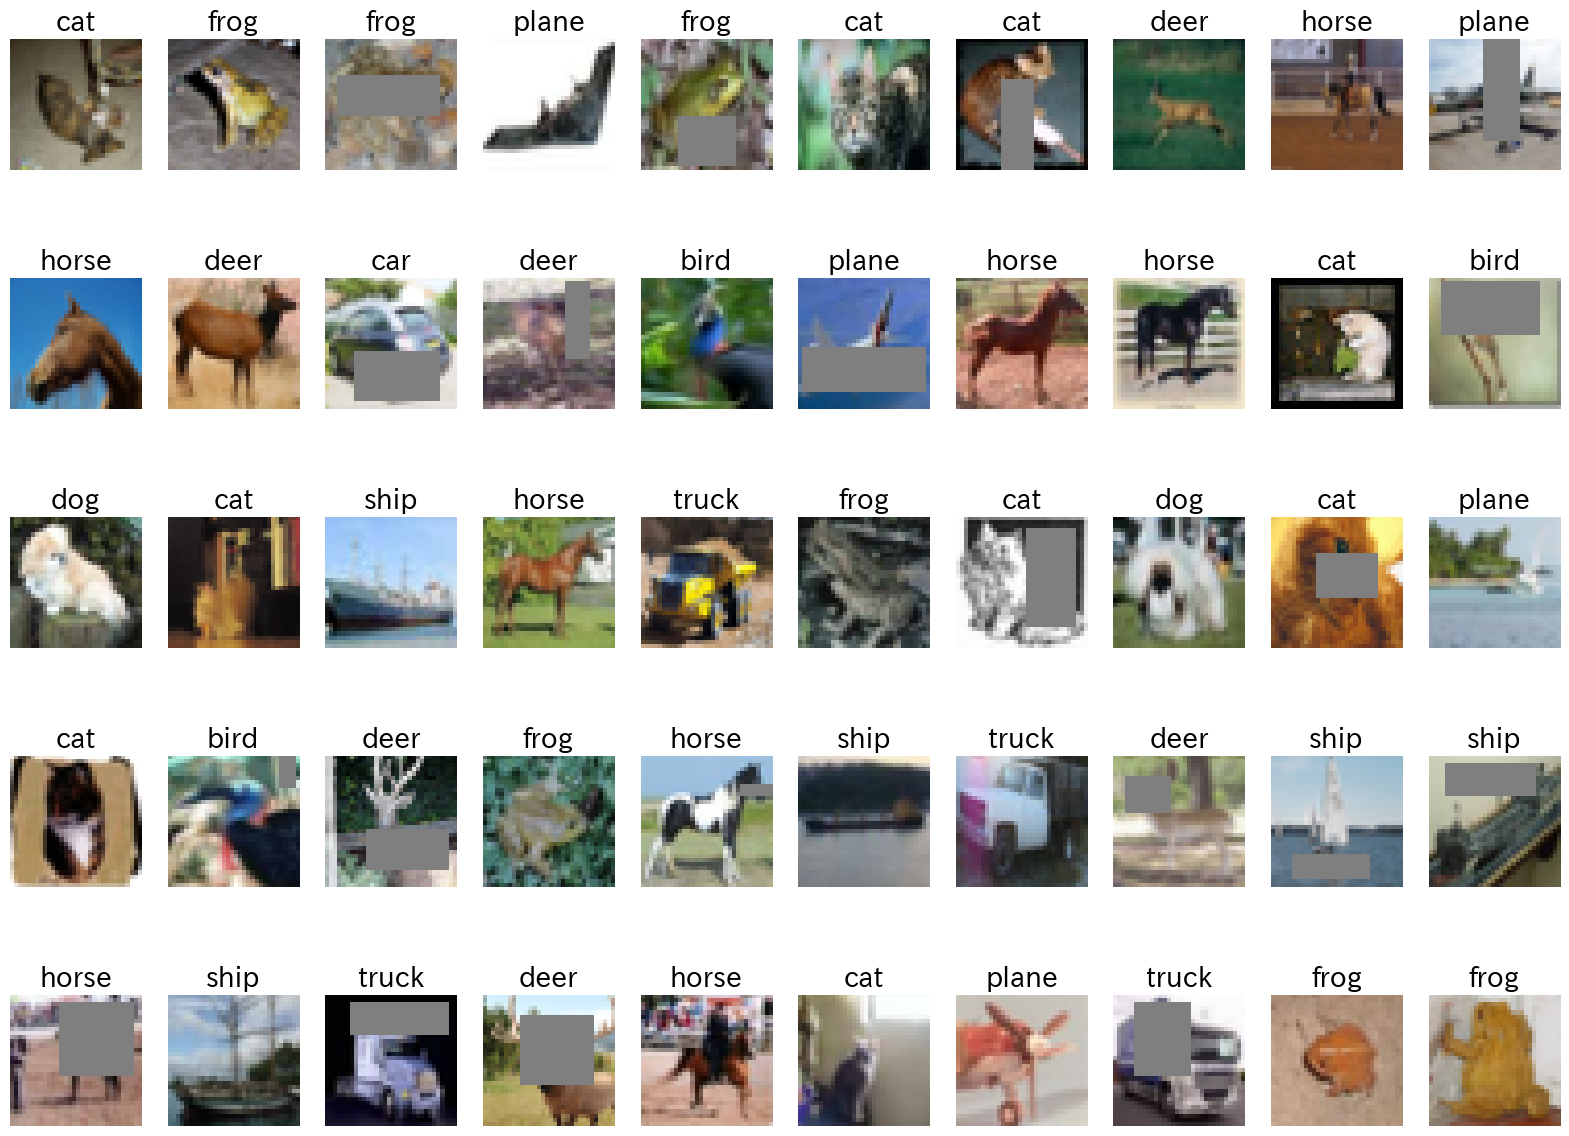

In [14]:
show_images_labels(train_loader, classes, None, None)

In [15]:
class CNN_v4(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1))
        self.conv2 = nn.Conv2d(32, 32, 3, padding=(1,1))
        self.conv3 = nn.Conv2d(32, 64, 3, padding=(1,1))
        self.conv4 = nn.Conv2d(64, 64, 3, padding=(1,1))
        self.conv5 = nn.Conv2d(64, 128, 3, padding=(1,1))
        self.conv6 = nn.Conv2d(128, 128, 3, padding=(1,1))
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d((2,2))
        self.l1 = nn.Linear(4*4*128, 128)
        self.l2 = nn.Linear(128, num_classes)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(128)
        self.bn6 = nn.BatchNorm2d(128)

        self.features = nn.Sequential(
            self.conv1,
            self.bn1,
            self.relu,
            self.conv2,
            self.bn2,
            self.relu,
            self.maxpool,
            self.dropout1,
            self.conv3,
            self.bn3,
            self.relu,
            self.conv4,
            self.bn4,
            self.relu,
            self.maxpool,
            self.dropout2,
            self.conv5,
            self.bn5,
            self.relu,
            self.conv6,
            self.bn6,
            self.relu,
            self.maxpool,
            self.dropout3,
            )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.dropout3,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

In [16]:
# 学習用関数
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):

    base_epochs = len(history)

    for epoch in range(base_epochs, num_epochs+base_epochs):
        # 1エポックあたりの正解数(精度計算用)
        n_train_acc, n_val_acc = 0, 0
        # 1エポックあたりの累積損失(平均化前)
        train_loss, val_loss = 0, 0
        # 1エポックあたりのデータ累積件数
        n_train, n_test = 0, 0

        #訓練フェーズ
        net.train()

        for inputs, labels in tqdm(train_loader):
            # 1バッチあたりのデータ件数
            train_batch_size = len(labels)
            # 1エポックあたりのデータ累積件数
            n_train += train_batch_size

            # GPUヘ転送
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 勾配の初期化
            optimizer.zero_grad()

            # 予測計算
            outputs = net(inputs)

            # 損失計算
            loss = criterion(outputs, labels)

            # 勾配計算
            loss.backward()

            # パラメータ修正
            optimizer.step()

            # 予測ラベル導出
            predicted = torch.max(outputs, 1)[1]

            # 平均前の損失と正解数の計算
            # lossは平均計算が行われているので平均前の損失に戻して加算
            train_loss += loss.item() * train_batch_size
            n_train_acc += (predicted == labels).sum().item()

        #予測フェーズ
        net.eval()

        for inputs_test, labels_test in test_loader:
            # 1バッチあたりのデータ件数
            test_batch_size = len(labels_test)
            # 1エポックあたりのデータ累積件数
            n_test += test_batch_size

            # GPUヘ転送
            inputs_test = inputs_test.to(device)
            labels_test = labels_test.to(device)

            # 予測計算
            outputs_test = net(inputs_test)

            # 損失計算
            loss_test = criterion(outputs_test, labels_test)

            # 予測ラベル導出
            predicted_test = torch.max(outputs_test, 1)[1]

            #  平均前の損失と正解数の計算
            # lossは平均計算が行われているので平均前の損失に戻して加算
            val_loss +=  loss_test.item() * test_batch_size
            n_val_acc +=  (predicted_test == labels_test).sum().item()

        # 精度計算
        train_acc = n_train_acc / n_train
        val_acc = n_val_acc / n_test
        # 損失計算
        avg_train_loss = train_loss / n_train
        avg_val_loss = val_loss / n_test
        # 結果表示
        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {val_acc:.5f}')
        # 記録
        item = np.array([epoch+1, avg_train_loss, train_acc, avg_val_loss, val_acc])
        history = np.vstack((history, item))
    return history

In [17]:
# PyTorch乱数固定用
def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

In [18]:
# 学習ログ解析
def evaluate_history(history):
    #損失と精度の確認
    print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}')
    print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

    num_epochs = len(history)
    unit = num_epochs / 10

    # 学習曲線の表示 (損失)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,1], 'b', label='訓練')
    plt.plot(history[:,0], history[:,3], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('損失')
    plt.title('学習曲線(損失)')
    plt.legend()
    plt.show()

    # 学習曲線の表示 (精度)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,2], 'b', label='訓練')
    plt.plot(history[:,0], history[:,4], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('精度')
    plt.title('学習曲線(精度)')
    plt.legend()
    plt.show()


In [19]:
# 出力次元数
# 分類先クラス数　今回は10になる
n_output = len(classes)

# 隠れ層のノード数
# n_hidden = 128

# モデルインスタンス生成
net = CNN_v4(n_output).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

# 繰り返し回数
num_epochs = 100

# 評価結果記録用
history = np.zeros((0,5))


In [21]:
# 学習
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

初期状態: 損失: 1.24958 精度: 0.54360
最終状態: 損失: 0.46079 精度: 0.86630


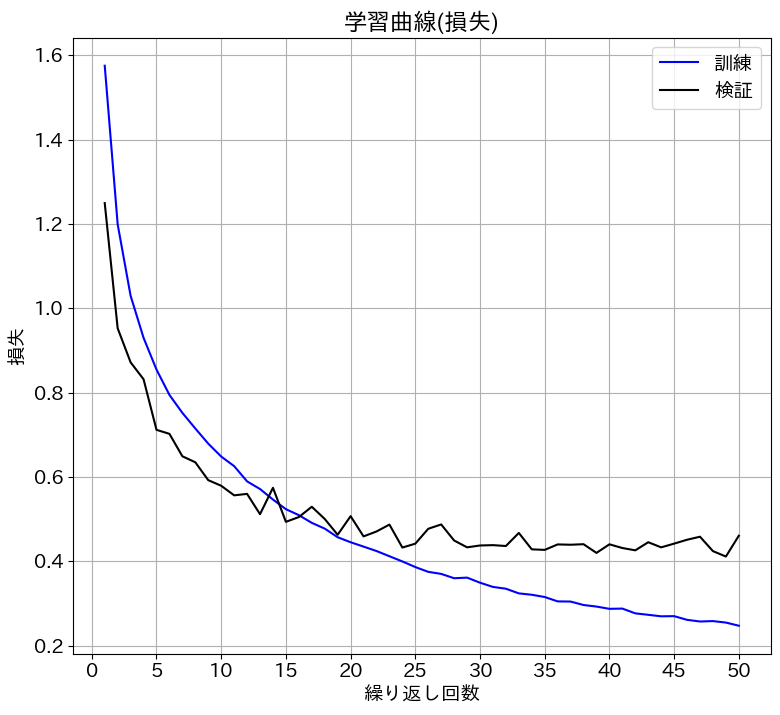

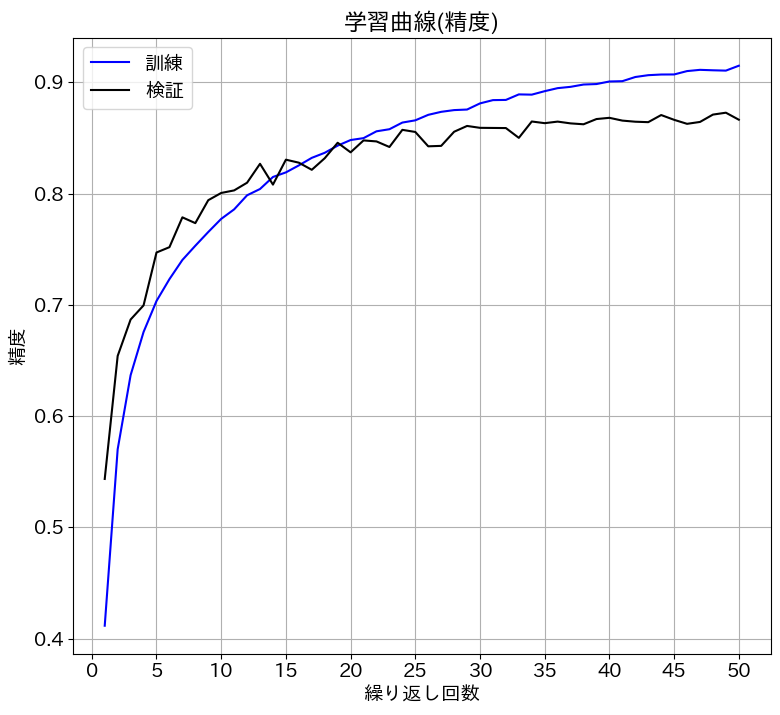

In [ ]:
# 評価
evaluate_history(history)

In [ ]:
# 最初の50個の表示
show_images_labels(test_loader, classes, net, device)